In [1]:
%matplotlib inline
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

[dasch search](http://dasch.rc.fas.harvard.edu/lightcurve_frame.php?coo=19+50+50.248+%2B48+04+51.09&nmin=1&box=5&source=apass&frameformat=frame&submit=Search) [dasch data table source](http://dasch.rc.fas.harvard.edu/tmp/VNhUwJ/fullshort_T356120921.db?GetData=Show+Lightcurve+Summary+Data+%28All+points%29)

In [2]:
table = ascii.read('fullshort_T356120921.db.txt', delimiter='\t', data_start=8, header_start=5)

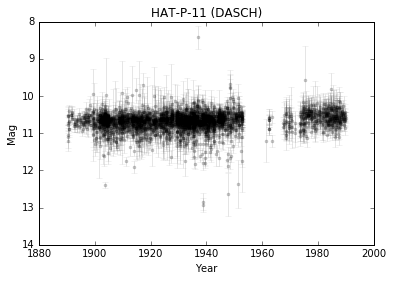

In [3]:
mag = table['magcal_magdep'].data
times = Time(table['Date'], format='jd')
err = table['magcal_local_rms'].data

valid = (mag != 0) & (err < 1)
mag = mag[valid]
times = times[valid]
err = err[valid]

fig, ax = plt.subplots()
ax.errorbar(times.decimalyear, mag, err, fmt='.', color='k', ecolor='gray', alpha=0.2)
ax.invert_yaxis()
ax.set(xlabel='Year', ylabel='Mag', title='HAT-P-11 (DASCH)')
fig.savefig('full_lc.png')

In [4]:
from gatspy import periodic

#model = periodic.LombScargleFast(fit_period=True)

model = periodic.LombScargle(fit_period=True)

model.optimizer.period_range = (2, 20)

model.fit(times.decimalyear, mag, err);

Finding optimal frequency:
 - Estimated peak width = 0.0631
 - Using 5 steps per peak; omega_step = 0.0126
 - User-specified period range:  2 to 20
 - Computing periods at 226 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


In [5]:
!mkdir plots

mkdir: plots: File exists


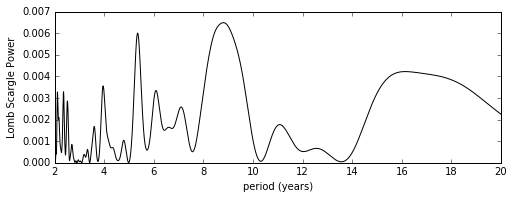

In [6]:
# Compute the scores on a grid of periods
periods = np.linspace(model.optimizer.period_range[0], 
                      model.optimizer.period_range[1], 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 3))
fig.subplots_adjust(bottom=0.2)
ax.plot(periods, scores, color='k')
ax.set(xlabel='period (years)', ylabel='Lomb Scargle Power')
fig.savefig('plots/periodogram.png', bbox_inches='tight', dpi=100)

(11.2, 10.2)

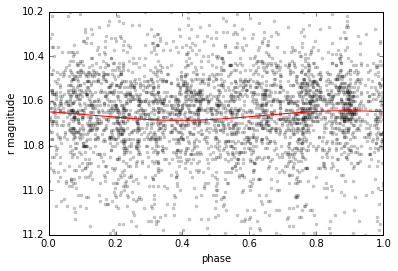

In [7]:
# Predict on a regular phase grid
period = model.best_period
tfit = np.linspace(0, period, 1000)
magfit = model.predict(tfit)

# Plot the results
phase = (times.decimalyear / period) % 1
phasefit = (tfit / period)

fig, ax = plt.subplots()
#ax.errorbar(phase, mag, err, fmt='o')
ax.plot(phase, mag, 'k.', alpha=0.2)
ax.plot(phasefit, magfit, '-', color='r')
ax.set(xlabel='phase', ylabel='r magnitude')
ax.invert_yaxis()
ax.set_ylim([11.2, 10.2])

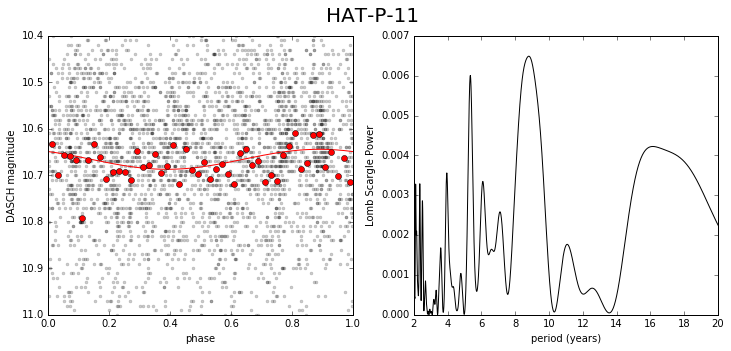

In [8]:
# Predict on a regular phase grid
period = model.best_period
tfit = np.linspace(0, period, 1000)
magfit = model.predict(tfit)

# Plot the results
phase = (times.decimalyear / period) % 1
phasefit = (tfit / period)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax.errorbar(phase, mag, err, fmt='o')
ax[0].plot(phase, mag, 'k.', alpha=0.2)
ax[0].plot(phasefit, magfit, '-', color='r')

from scipy.stats import binned_statistic

binned = binned_statistic(phase, mag, statistic='mean', bins=50)
times_binned = 0.5*(binned.bin_edges[:-1] + binned.bin_edges[1:])
mags_binned = binned.statistic

ax[0].plot(times_binned, mags_binned, 'ro')
ax[0].set(xlabel='phase', ylabel='DASCH magnitude')
ax[0].invert_yaxis()
ax[0].set_ylim([11., 10.4])

ax[1].plot(periods, scores, color='k')
ax[1].set(xlabel='period (years)', ylabel='Lomb Scargle Power')
fig.suptitle("HAT-P-11", fontsize=20)
fig.savefig('plots/phase_folded.png')
plt.show()

In [9]:
import celerite
from celerite import terms
from scipy.optimize import minimize

from cerotate.k2 import get_light_curve
from cerotate.rotation_term import RotationTerm

flux = mag
t = times.decimalyear

log_var = np.log(np.var(flux))
kernel = RotationTerm(
    log_a=log_var,
    log_b=-0.1,
    log_f=-5.0,
    log_P=np.log(period),
    bounds=dict(
        log_a=(-10.0, 10.0),
        log_b=(-5.0, 5.0),
        log_f=(-5.0, 5.0),
        log_P=(np.log(0.5), np.log(30)),
    ),
)

kernel += terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2),
    log_omega0=np.log(2*np.pi/10.0),
    bounds=dict(
        log_S0=(-20.0, 20.0),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0))
    )
)
kernel.terms[1].freeze_parameter("log_Q")

kernel += terms.JitterTerm(log_sigma=np.log(np.median(np.abs(np.diff(flux)))),
                           bounds=[(-10.0, 10.0)])
gp = celerite.GP(kernel)
gp.compute(t)

def nll(params):
    gp.set_parameter_vector(params)
    try:
        return -gp.log_likelihood(flux)
    except celerite.solver.LinAlgError:
        return 1e10

def grad_nll(params):
    gp.set_parameter_vector(params)
    try:
        return -gp.grad_log_likelihood(flux)[1]
    except celerite.solver.LinAlgError:
        return np.zeros_like(params)

bounds = gp.get_parameter_bounds()
p0 = gp.get_parameter_vector()
soln = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", bounds=bounds)
print(soln)

x = np.linspace(t.min() - 3, t.max() + 3, 5000)
pred_mu, pred_var = gp.predict(flux, x, return_var=True)
pred_sig = np.sqrt(pred_var)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, flux, ".k", ms=3)
ax.plot(x, pred_mu, "g", lw=0.7)
ax.fill_between(x, pred_mu+pred_sig, pred_mu-pred_sig, color="g",
                alpha=0.5, lw=0)
ax.set_ylabel("relative flux [pph]")
ax.set_xlabel("time [days]")
ax.set_xlim(x.min(), x.max())

ml_period = np.exp(gp.kernel.terms[0].log_P)
ax.annotate("period = {0:.3f} d".format(ml_period),
            xy=(1, 1), xycoords="axes fraction",
            ha="right", va="top", xytext=(-5, -5), textcoords="offset points");

AttributeError: module 'celerite.solver' has no attribute 'LinAlgError'